In [42]:
from math import sin, cos, log
import numpy
from matplotlib import pyplot
%matplotlib inline
from matplotlib import rcParams
rcParams['font.family']='serif'
rcParams['font.size']=16

In [43]:
#model params:
g=9.8 #[m/s^2]
v_t = 5.0 #[m/s] trim velocity
C_D = 1/5.0 #coeff of drag (D/L when C_L=1)
C_L = 1.0 #coeff of lift

#ICs
v0 = 6.5
theta0 = -0.1
x0 = 0.0
y0 = 2.0

In [44]:
def f(u):
    '''Returns RHS of phugoid system of eqns.
    
    Parameters:
        u: array containing solution at time n
        
    Returns: 
        dudt: array containting the RHS given u
    '''
    
    v = u[0]
    theta = u[1]
    x = u[2]
    y = u[3]
    #print(v)
    return numpy.array([-g*numpy.sin(theta) - C_D/C_L*g/v_t**2*v**2,
                       -g*numpy.cos(theta)/v + g/v_t**2*v,
                       v*numpy.cos(theta),
                       v*numpy.sin(theta)])
    
def euler(u, f, dt):
    '''Returns solution at next time step using Eulers method
    
    Parameters:
        u: soln. at previous time step
        f: function
        dt
        
    Returns:
        u[n+1] approximate solution at next time step
    '''
    return u+ dt*f(u)
    
def get_diffgrid(u_current, u_fine, dt):
    '''Returns difference between current grid and finest grid using L-1 norm
    
    Params:
        u_current: soln on current grid
        u_finest: soln on the finest grid
        dt
        
    returns:
        diffgrid: difference computed in L-1 norm
    
    '''
    
    N_current = len(u_current[:,0])
    N_fine = len(u_fine[:,0])
    
    grid_size_ratio = numpy.ceil(N_fine/N_current)
    diffgrid = dt*numpy.sum(numpy.abs(u_current[:,2] - u_fine[::grid_size_ratio,2]))
    
    return diffgrid

In [45]:
def rk2(u, f, dt):
    ''' Returns the solution at next time step using second order RK method
    
    Parameters: 
        u: sol. at previous time step
        f: funtion to compute RHS of system of eqns.
        dt
        
    Returns:
        u(n+1): solution at next time step.
    '''
    u_star = u + 0.5*dt*f(u)
    return u + dt*f(u_star)


In [46]:
#discretize time step
T = 15.0
dt = 0.01
N = int(T/dt) + 1

#ICs
u_euler = numpy.empty((N,4))
u_rk2 = numpy.empty((N,4))

#initialize arrays
u_euler[0] = numpy.array([v0, theta0, x0, y0])
u_rk2[0] = numpy.array([v0, theta0, x0, y0])

for n in range(N-1):
    u_euler[n+1] = euler(u_euler[n], f, dt)
    u_rk2[n+1] = rk2(u_rk2[n], f, dt)

In [47]:
x_euler = u_euler[:,2]
y_euler = u_euler[:,3]
x_rk2 = u_rk2[:,2]
y_rk2 = u_rk2[:,3]

In [48]:
idx_negative_euler = numpy.where(y_euler<0.0)[0]
if len(idx_negative_euler)==0:
    idx_ground_euler = N-1
    print('Euler is still running')
else:
    idx_ground_euler = idx_negative_euler[0]

idx_negative_rk2 = numpy.where(y_rk2<0.0)[0]
if len(idx_negative_rk2)==0:
    idx_ground_rk2 = N-1
    print('RK is still running')
else:
    idx_ground_rk2 = idx_negative_rk2[0]

In [49]:
# check to see if the paths match
print('Are the x-values close? {}'.format(numpy.allclose(x_euler, x_rk2)))
print('Are the y-values close? {}'.format(numpy.allclose(y_euler, y_rk2)))

Are the x-values close? False
Are the y-values close? False


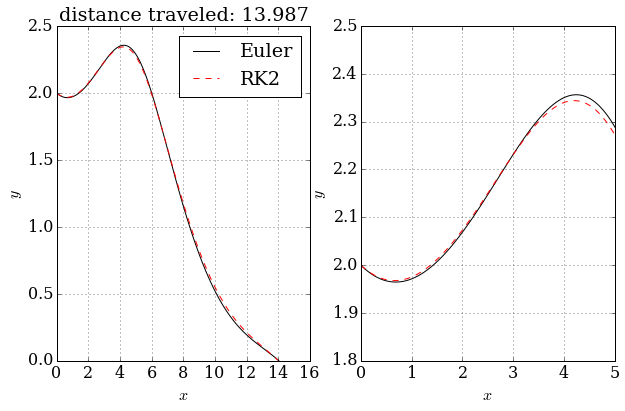

In [50]:
# plot the glider path
pyplot.figure(figsize=(10,6))
pyplot.subplot(121)
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.plot(x_euler[:idx_ground_euler], y_euler[:idx_ground_euler], 'k-', label='Euler')
pyplot.plot(x_rk2[:idx_ground_rk2], y_rk2[:idx_ground_rk2], 'r--', label='RK2')
pyplot.title('distance traveled: {:.3f}'.format(x_rk2[idx_ground_rk2-1]))
pyplot.legend();

#zoom in
pyplot.subplot(122)
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.plot(x_euler, y_euler, 'k-', label='Euler')
pyplot.plot(x_rk2, y_rk2, 'r--', label='RK2')
pyplot.xlim(0,5)
pyplot.ylim(1.8,2.5);

In [51]:
dt_values = numpy.array([0.1, 0.05, 0.01, 0.005, .001])
u_values = numpy.empty_like(dt_values, dtype=numpy.ndarray)

for i, dt in enumerate(dt_values):
    N= int(T/dt)+1
    t = numpy.linspace(0.0, T, N)
    u = numpy.empty((N,4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    
    for n in range(N-1):
        u[n+1] = rk2(u[n], f, dt)
    
    u_values[i] = u

In [52]:
diffgrid = numpy.empty_like(dt_values)
for i, dt in enumerate(dt_values):
    diffgrid[i] = get_diffgrid(u_values[i], u_values[-1], dt)

/opt/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:51: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


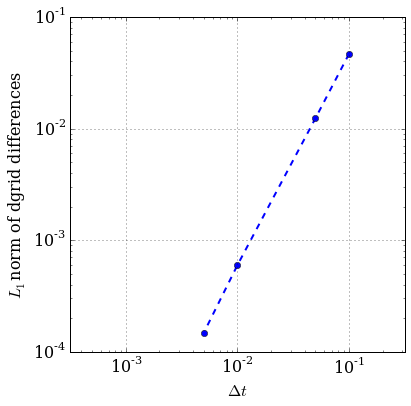

In [53]:
pyplot.figure(figsize=(6,6))
pyplot.grid(True)
pyplot.xlabel(r'$\Delta t$', fontsize=16)
pyplot.ylabel(r'$L_1$norm of dgrid differences', fontsize=16)
pyplot.xlim(1e-4,2)
pyplot.ylim(1e-4,1)
pyplot.axis('equal')
pyplot.loglog(dt_values[:-1], diffgrid[:-1], ls='--', lw=2, marker='o');

In [54]:
%%time
r=2
h=.001

dt_values = numpy.array([h, r*h, r**2*h])
u_values = numpy.empty_like(dt_values, dtype=numpy.ndarray)

for i, dt in enumerate(dt_values):
    N= int(T/dt)+1
    t=numpy.linspace(0.0, T, N)
    u = numpy.empty((N,4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    
    for n in range(N-1):
        u[n+1] = rk2(u[n], f, dt)
        
    u_values[i] = u
    
alpha = (log(get_diffgrid(u_values[2], u_values[1], dt_values[2])) -log(get_diffgrid(u_values[1], u_values[0], dt_values[1])))/log(r)

print('The order of convergence is alpha = {:3f}'.format(alpha))

The order of convergence is alpha = 1.984342
CPU times: user 734 ms, sys: 16 ms, total: 750 ms
Wall time: 709 ms


/opt/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:51: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


In [55]:
%%time
r=2
h=.001

dt_values = numpy.array([h, r*h, r**2*h])
u_values = numpy.empty_like(dt_values, dtype=numpy.ndarray)

for i, dt in enumerate(dt_values):
    N= int(T/dt)+1
    t=numpy.linspace(0.0, T, N)
    u = numpy.empty((N,4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    
    for n in range(N-1):
        u[n+1] = euler(u[n], f, dt)
        
    u_values[i] = u
    
alpha = (log(get_diffgrid(u_values[2], u_values[1], dt_values[2])) -log(get_diffgrid(u_values[1], u_values[0], dt_values[1])))/log(r)

print('The order of convergence is alpha = {:3f}'.format(alpha))

The order of convergence is alpha = 1.029802
CPU times: user 420 ms, sys: 12 ms, total: 432 ms
Wall time: 403 ms


/opt/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:51: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


Challenge Task: timing

The second order Runge-Kutta method runs in a total time of 1.2s, while the first order Euler method runs in 0.747s.

In [56]:
def leapfrog(un1, u, f, dt):
    
    return un1 + 2.0*dt*f(u)


In [57]:
g = 9.8
v_t = 5.0
C_D = 1/5.0
C_L = 1.0
#ICs
v0 = 6.5
theta0 = -0.1
x0 = 0.0
y0= 2.0

T=15.0
dt = 0.01
N= int(T/dt) +1

u_leapfrog = numpy.empty((N,4))
u_leapfrog[0] = numpy.array([v0, theta0, x0, y0])

u_leapfrog[1] = rk2(u_leapfrog[0], f, dt)

In [58]:
for n in range(1,N-1):
    u_leapfrog[n+1] = leapfrog(u_leapfrog[n-1], u_leapfrog[n], f, dt)

In [59]:
x_leapfrog = u_leapfrog[:,2]
y_leapfrog = u_leapfrog[:,3]

idx_negative_leapfrog = numpy.where(y_leapfrog<0.0)[0]

if len(idx_negative_leapfrog)==0:
    idx_ground_leapfrog= N-1
    pring('still running')
else:
    idx_ground_leapfrog = idx_negative_leapfrog[0]



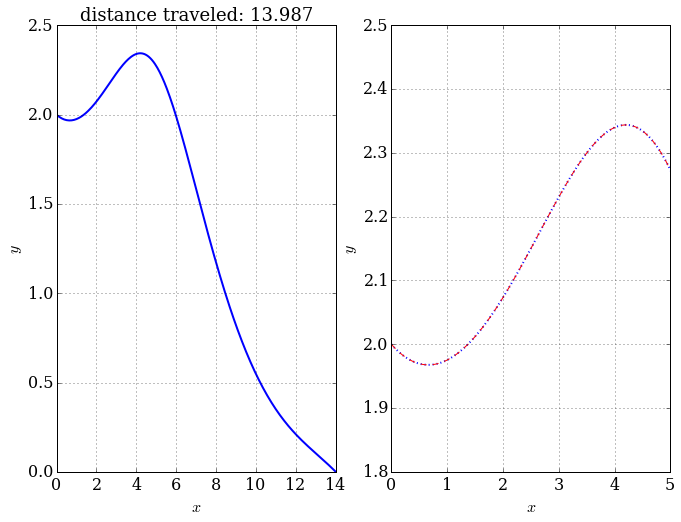

In [60]:
pyplot.figure(figsize=(11,8))
pyplot.subplot(121)
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.plot(x_leapfrog[:idx_ground_leapfrog], y_leapfrog[:idx_ground_leapfrog], ls='-', lw=2)
pyplot.title('distance traveled: {:.3f}'.format(x_leapfrog[idx_ground_leapfrog-1]), fontsize=18);

# Let's take a closer look!
pyplot.subplot(122)
pyplot.grid(True)
pyplot.xlabel('$x$')
pyplot.ylabel('$y$')
pyplot.plot(x_leapfrog[:idx_ground_leapfrog], y_leapfrog[:idx_ground_leapfrog], ls=':', lw=2)
pyplot.plot(x_rk2, y_rk2, 'r--', label='RK2')
pyplot.xlim(0,5)
pyplot.ylim(1.8,2.5);

In [61]:
r=2
h=.001

dt_values = numpy.array([h, r*h, r**2*h])
u_values = numpy.empty_like(dt_values, dtype=numpy.ndarray)

for i, dt in enumerate(dt_values):
    N= int(T/dt)+1
    t=numpy.linspace(0.0, T, N)
    u = numpy.empty((N,4))
    u[0] = numpy.array([v0, theta0, x0, y0])
    
    u[1] = rk2(u[0], f, dt)
    for n in range(N-1):
        u[n+1] = leapfrog(u[n-1], u[n], f, dt)
        
    u_values[i] = u
    
alpha = (log(get_diffgrid(u_values[2], u_values[1], dt_values[2])) -log(get_diffgrid(u_values[1], u_values[0], dt_values[1])))/log(r)

print('The order of convergence is alpha = {:3f}'.format(alpha))

/opt/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:16: RuntimeWarning: overflow encountered in double_scalars
/opt/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:16: RuntimeWarning: invalid value encountered in sin
/opt/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:17: RuntimeWarning: invalid value encountered in cos
/opt/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in cos
/opt/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:19: RuntimeWarning: invalid value encountered in sin
/opt/anaconda/lib/python3.4/site-packages/ipykernel/__main__.py:51: DeprecationWarning: using a non-integer number instead of an integer will result in an error in the future


The order of convergence is alpha = nan
